# RFGBoost tuning

Author: https://github.com/deburky

In [ ]:
from pathlib import Path

import colormaps as cmaps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LightSource
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split

from rfgboost import RFGBoost

In [2]:
ROOT_DIR = Path.cwd().parent
dataset = pd.read_csv(ROOT_DIR / "data" / "BankCaseStudyData.csv")

# Prepare features and labels
label = "Final_Decision"
dataset[label] = dataset[label].map({"Accept": 0, "Decline": 1})

num_features = [
    "Application_Score",
    "Bureau_Score",
    "Loan_Amount",
    "Time_with_Bank",
    "Time_in_Employment",
    "Loan_to_income",
    "Gross_Annual_Income",
]

cat_features = [
    "Loan_Payment_Frequency",
    "Residential_Status",
    "Cheque_Card_Flag",
    "Existing_Customer_Flag",
    "Home_Telephone_Number",
]

features = cat_features + num_features

ix_train = dataset["split"] == "Development"
ix_test = dataset["split"] == "Validation"

X_train = dataset.loc[ix_train, features]
y_train = dataset.loc[ix_train, label]
X_test = dataset.loc[ix_test, features]
y_test = dataset.loc[ix_test, label]

X_train.loc[:, cat_features] = X_train.loc[:, cat_features].astype(str).fillna("NA")
X_test.loc[:, cat_features] = X_test.loc[:, cat_features].astype(str).fillna("NA")

# Run RFGBoost

# Configure and train our RandomForestGradientBoosting model
rf_params = {
    "n_estimators": 10,  # Number of trees in each Random Forest
    "max_depth": 4,
    "ccp_alpha": 0.0,  # Fraction of samples to use for each tree
    "random_state": 0,  # For reproducibility
}

rfgb_model = RFGBoost(
    n_estimators=10,  # Number of boosting iterations, same as CatBoost
    rf_params=rf_params,
    learning_rate=0.5,
    task="classification",
    cat_features=cat_features,
)

# Fit the model
rfgb_model.fit(X_train, y_train)
rfgb_pred = rfgb_model.predict(X_test)

# Calculate Gini coefficient (same as for CatBoost)
rfgb_gini = 2 * roc_auc_score(y_test, rfgb_pred) - 1
print(f"RFGBoost Gini: {rfgb_gini:.4f}")

print(rfgb_pred.max())

/Users/deburky/Documents/python/rfgboost/rfgboost/rfgboost.py:265: UserWarning: Input y is a numpy array. Converting to pandas Series. For better control, convert to Series before passing to fit().
  self.woe_encoder.fit(X_cat, y_numeric)
/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/fastwoe/fastwoe.py:245: RuntimeWarning: divide by zero encountered in scalar divide
  variance = 1.0 / (p * (1.0 - p) * n)  # log-odds variance


RFGBoost Gini: 0.6246
1


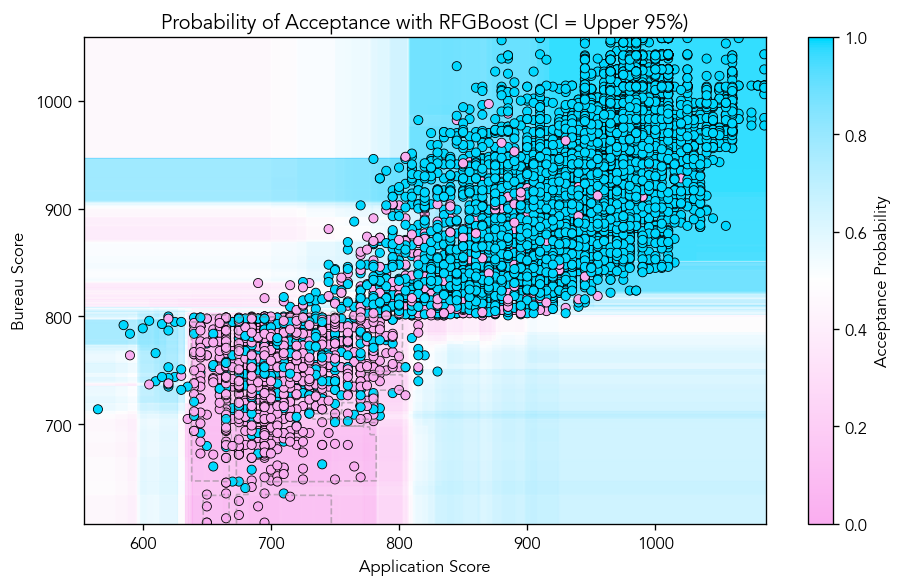

In [3]:
cmap2 = cmaps.cet_d_cwm_8_r

# Set font to Avenir
plt.rcParams["font.family"] = "Avenir"

# Load dataset
dataset = pd.read_csv(ROOT_DIR / "data" / "BankCaseStudyData.csv")
label = "Final_Decision"

X = dataset[["Application_Score", "Bureau_Score"]]
y = dataset[label].map({"Accept": 1, "Decline": 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Model
model = RFGBoost(
    n_estimators=5,
    rf_params={"n_estimators": 10, "max_depth": 5},
    learning_rate=0.1,
    task="classification",
)
model.fit(X_train, y_train)

# Meshgrid
x_min, x_max = X["Application_Score"].min() - 1, X["Application_Score"].max() + 1
y_min, y_max = X["Bureau_Score"].min() - 1, X["Bureau_Score"].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_df = pd.DataFrame(grid, columns=["Application_Score", "Bureau_Score"])

# Predictions and CIs
Z_mean = model.predict_proba(grid_df)[:, 1].reshape(xx.shape)
ci = model.predict_ci(grid_df, alpha=0.05)
Z_upper = ci[:, 1].reshape(xx.shape)

# Light source shading
ls = LightSource(azdeg=315, altdeg=45)
shaded_surface = ls.shade(Z_mean, cmap=cmap2, vert_exag=3, blend_mode="soft")


# Plot
fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
ax.imshow(
    shaded_surface,
    extent=(x_min, x_max, y_min, y_max),
    origin="lower",
    aspect="auto",
    cmap=cmap2,
    alpha=0.8,
)

# Confidence interval upper bounds as terrain ridges
cont = ax.contour(
    xx,
    yy,
    Z_upper,
    levels=1,
    colors="grey",
    linewidths=1,
    alpha=0.5,
    linestyles="dashed",
)
ax.clabel(cont, inline=True, fontsize=9, fmt="CI %.2f")

# Training data overlay
scatter = ax.scatter(
    X_train["Application_Score"],
    X_train["Bureau_Score"],
    c=y_train,
    cmap=cmap2,
    edgecolor="k",
    linewidth=0.5,
    alpha=1.0,
    s=30,
)

Z_lower = ci[:, 0].reshape(xx.shape)
Z_width = Z_upper - Z_lower

uncertainty_overlay = ax.contourf(xx, yy, Z_width, levels=10, cmap="Greys", alpha=0)
ax.set_xlabel("Application Score")
ax.set_ylabel("Bureau Score")
ax.set_title("Probability of Acceptance with RFGBoost (CI = Upper 95%)")
plt.colorbar(scatter, ax=ax, label="Acceptance Probability")
plt.tight_layout()
plt.show()

In [4]:
# Define parameter grid (FIXED)
param_grid = {
    "n_estimators": [3, 5, 7],  # RFGBoost boosting rounds
    "learning_rate": [0.1, 0.5, 1.0],  # RFGBoost learning rate
    "rf_params__n_estimators": [5, 10],  # RF trees per round (NESTED!)
    "rf_params__max_depth": [3, 5, None],  # RF max depth (NESTED!)
}


# Custom scorer function (FIXED - avoids needs_proba issue)
def log_loss_scorer(estimator, X, y):
    y_pred_proba = estimator.predict_proba(X)[:, 1]
    return -log_loss(y, y_pred_proba)


# Use GridSearchCV to evaluate combinations (FIXED)
grid = GridSearchCV(
    RFGBoost(task="classification"),
    param_grid=param_grid,
    scoring=log_loss_scorer,
    cv=3,
    verbose=2,
    n_jobs=1,  # Using 1 job for cleaner output
)

print("Running GridSearchCV...")
grid.fit(X, y)

# Print best config
print("\n✅ Best Parameters:")
print(grid.best_params_)
print(f"Log Loss: {-grid.best_score_:.4f}")

Running GridSearchCV...
Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END learning_rate=0.1, n_estimators=3, rf_params__max_depth=3, rf_params__n_estimators=5; total time=   0.1s
[CV] END learning_rate=0.1, n_estimators=3, rf_params__max_depth=3, rf_params__n_estimators=5; total time=   0.1s
[CV] END learning_rate=0.1, n_estimators=3, rf_params__max_depth=3, rf_params__n_estimators=5; total time=   0.1s
[CV] END learning_rate=0.1, n_estimators=3, rf_params__max_depth=3, rf_params__n_estimators=10; total time=   0.1s
[CV] END learning_rate=0.1, n_estimators=3, rf_params__max_depth=3, rf_params__n_estimators=10; total time=   0.1s
[CV] END learning_rate=0.1, n_estimators=3, rf_params__max_depth=3, rf_params__n_estimators=10; total time=   0.1s
[CV] END learning_rate=0.1, n_estimators=3, rf_params__max_depth=5, rf_params__n_estimators=5; total time=   0.1s
[CV] END learning_rate=0.1, n_estimators=3, rf_params__max_depth=5, rf_params__n_estimators=5; total time=   0.1s

/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)
/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)
/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)
/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values a

[CV] END learning_rate=1.0, n_estimators=3, rf_params__max_depth=3, rf_params__n_estimators=10; total time=   0.1s
[CV] END learning_rate=1.0, n_estimators=3, rf_params__max_depth=3, rf_params__n_estimators=10; total time=   0.1s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)
/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=3, rf_params__max_depth=3, rf_params__n_estimators=10; total time=   0.1s
[CV] END learning_rate=1.0, n_estimators=3, rf_params__max_depth=5, rf_params__n_estimators=5; total time=   0.1s
[CV] END learning_rate=1.0, n_estimators=3, rf_params__max_depth=5, rf_params__n_estimators=5; total time=   0.1s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)
/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)
/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=3, rf_params__max_depth=5, rf_params__n_estimators=5; total time=   0.1s
[CV] END learning_rate=1.0, n_estimators=3, rf_params__max_depth=5, rf_params__n_estimators=10; total time=   0.1s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)
/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=3, rf_params__max_depth=5, rf_params__n_estimators=10; total time=   0.2s
[CV] END learning_rate=1.0, n_estimators=3, rf_params__max_depth=5, rf_params__n_estimators=10; total time=   0.1s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)
/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=3, rf_params__max_depth=None, rf_params__n_estimators=5; total time=   0.2s
[CV] END learning_rate=1.0, n_estimators=3, rf_params__max_depth=None, rf_params__n_estimators=5; total time=   0.2s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)
/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=3, rf_params__max_depth=None, rf_params__n_estimators=5; total time=   0.2s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=3, rf_params__max_depth=None, rf_params__n_estimators=10; total time=   0.3s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=3, rf_params__max_depth=None, rf_params__n_estimators=10; total time=   0.3s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=3, rf_params__max_depth=None, rf_params__n_estimators=10; total time=   0.3s
[CV] END learning_rate=1.0, n_estimators=5, rf_params__max_depth=3, rf_params__n_estimators=5; total time=   0.1s
[CV] END learning_rate=1.0, n_estimators=5, rf_params__max_depth=3, rf_params__n_estimators=5; total time=   0.1s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)
/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)
/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=5, rf_params__max_depth=3, rf_params__n_estimators=5; total time=   0.1s
[CV] END learning_rate=1.0, n_estimators=5, rf_params__max_depth=3, rf_params__n_estimators=10; total time=   0.2s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)
/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=5, rf_params__max_depth=3, rf_params__n_estimators=10; total time=   0.2s
[CV] END learning_rate=1.0, n_estimators=5, rf_params__max_depth=3, rf_params__n_estimators=10; total time=   0.2s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)
/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=5, rf_params__max_depth=5, rf_params__n_estimators=5; total time=   0.1s
[CV] END learning_rate=1.0, n_estimators=5, rf_params__max_depth=5, rf_params__n_estimators=5; total time=   0.1s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)
/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=5, rf_params__max_depth=5, rf_params__n_estimators=5; total time=   0.1s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=5, rf_params__max_depth=5, rf_params__n_estimators=10; total time=   0.3s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=5, rf_params__max_depth=5, rf_params__n_estimators=10; total time=   0.3s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=5, rf_params__max_depth=5, rf_params__n_estimators=10; total time=   0.3s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=5, rf_params__max_depth=None, rf_params__n_estimators=5; total time=   0.3s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=5, rf_params__max_depth=None, rf_params__n_estimators=5; total time=   0.3s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=5, rf_params__max_depth=None, rf_params__n_estimators=5; total time=   0.3s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=5, rf_params__max_depth=None, rf_params__n_estimators=10; total time=   0.6s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=5, rf_params__max_depth=None, rf_params__n_estimators=10; total time=   0.6s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=5, rf_params__max_depth=None, rf_params__n_estimators=10; total time=   0.6s
[CV] END learning_rate=1.0, n_estimators=7, rf_params__max_depth=3, rf_params__n_estimators=5; total time=   0.1s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)
/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=7, rf_params__max_depth=3, rf_params__n_estimators=5; total time=   0.1s
[CV] END learning_rate=1.0, n_estimators=7, rf_params__max_depth=3, rf_params__n_estimators=5; total time=   0.1s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)
/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=7, rf_params__max_depth=3, rf_params__n_estimators=10; total time=   0.2s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=7, rf_params__max_depth=3, rf_params__n_estimators=10; total time=   0.2s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=7, rf_params__max_depth=3, rf_params__n_estimators=10; total time=   0.3s
[CV] END learning_rate=1.0, n_estimators=7, rf_params__max_depth=5, rf_params__n_estimators=5; total time=   0.2s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)
/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)
/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=7, rf_params__max_depth=5, rf_params__n_estimators=5; total time=   0.2s
[CV] END learning_rate=1.0, n_estimators=7, rf_params__max_depth=5, rf_params__n_estimators=5; total time=   0.2s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=7, rf_params__max_depth=5, rf_params__n_estimators=10; total time=   0.4s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=7, rf_params__max_depth=5, rf_params__n_estimators=10; total time=   0.4s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=7, rf_params__max_depth=5, rf_params__n_estimators=10; total time=   0.4s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=7, rf_params__max_depth=None, rf_params__n_estimators=5; total time=   0.4s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=7, rf_params__max_depth=None, rf_params__n_estimators=5; total time=   0.4s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=7, rf_params__max_depth=None, rf_params__n_estimators=5; total time=   0.5s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=7, rf_params__max_depth=None, rf_params__n_estimators=10; total time=   0.9s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=7, rf_params__max_depth=None, rf_params__n_estimators=10; total time=   0.9s


/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:859: UserWarning: Learning rate 1.0 is high and can cause instability. Typical values are 0.01 to 0.2.
  estimator.fit(X_train, y_train, **fit_params)


[CV] END learning_rate=1.0, n_estimators=7, rf_params__max_depth=None, rf_params__n_estimators=10; total time=   0.9s

✅ Best Parameters:
{'learning_rate': 0.5, 'n_estimators': 7, 'rf_params__max_depth': 3, 'rf_params__n_estimators': 10}
Log Loss: 0.1758
